In [1]:

%pprint
import sys
sys.path.insert(1, '../py')

Pretty printing has been turned OFF


In [2]:

import os
from pandas import DataFrame
import pandas as pd
from notebook_utils import NotebookUtilities
import matplotlib.pyplot as plt
import re
import humanize
from datetime import timedelta

nu = NotebookUtilities(data_folder_path=os.path.abspath('../data'))

In [3]:

# Get all CSVs into one data frame
if nu.pickle_exists('frvrs_logs_df'):
    frvrs_logs_df = nu.load_object('frvrs_logs_df')
    print(frvrs_logs_df.shape)
    # df = frvrs_logs_df.sample(4).dropna(axis='columns', how='all')
    # display(df.T)

(832366, 110)



# Triage Accuracy

(How many patients did they over- or under-tag.)


<img src="http://localhost:8888/files/itm-analysis-reporting/saves/png/error_table.png" />

In [4]:

if nu.pickle_exists('tag_to_salt_df'):
    tag_to_salt_df = nu.load_object('tag_to_salt_df')
    print(tag_to_salt_df.shape)
    df = tag_to_salt_df.sample(4).dropna(axis='columns', how='all')
    display(df.T)

(9874, 9)


,6221,1916,6745,3801
logger_version,1.0,1.0,1.0,1.3
session_uuid,a0987257-801e-44c5-a1ad-81e0083bfa46,2d26ca7b-1dbb-42e4-9bbf-bf0d131e2e06,af2f4603-a819-4d08-bc09-db30a910fc3f,60d2041e-9b37-4c13-a73d-906e6ecebd01
time_group,5,0,0,2
patient_id,Bob_0 Root,Lily_2 Root,Lily_7 Root,Gloria_6 Root
patient_count,1,1,1,1
last_tag,NaN,NaN,NaN,green
max_salt,NaN,NaN,NaN,DELAYED
predicted_tag,NaN,NaN,NaN,yellow
is_tag_correct,False,False,False,False



## Create the error table

In [5]:

error_table_df = pd.DataFrame([
    {'DEAD': 'Exact', 'EXPECTANT': 'Critical', 'IMMEDIATE': 'Critical', 'DELAYED': 'Critical', 'MINIMAL': 'Critical'},
    {'DEAD': 'Over', 'EXPECTANT': 'Exact', 'IMMEDIATE': 'Critical', 'DELAYED': 'Critical', 'MINIMAL': 'Critical'},
    {'DEAD': 'Over', 'EXPECTANT': 'Over', 'IMMEDIATE': 'Exact', 'DELAYED': 'Over', 'MINIMAL': 'Over'},
    {'DEAD': 'Over', 'EXPECTANT': 'Over', 'IMMEDIATE': 'Under', 'DELAYED': 'Exact', 'MINIMAL': 'Over'},
    {'DEAD': 'Over', 'EXPECTANT': 'Over', 'IMMEDIATE': 'Under', 'DELAYED': 'Under', 'MINIMAL': 'Exact'}
], columns=['DEAD', 'EXPECTANT', 'IMMEDIATE', 'DELAYED', 'MINIMAL'], index=['black', 'gray', 'red', 'yellow', 'green'])

In [6]:

df = error_table_df.sample(4).dropna(axis='columns', how='all')
display(df.T)

,black,red,green,gray
DEAD,Exact,Over,Over,Over
EXPECTANT,Critical,Over,Over,Exact
IMMEDIATE,Critical,Exact,Under,Critical
DELAYED,Critical,Over,Under,Critical
MINIMAL,Critical,Over,Exact,Critical



## Create the error type data frame

In [7]:

groupby_columns = ['last_tag', 'max_salt']
error_type_df = tag_to_salt_df.groupby(groupby_columns).patient_count.sum().to_frame()
def f(df):
    last_tag = df.name[0]
    # print(f'last_tag = {last_tag}')
    max_salt = df.name[1]
    # print(f'max_salt = {max_salt}')
    mask_series = (error_table_df.index == last_tag)
    error_type = error_table_df[mask_series][max_salt].squeeze()
    # print(f'error_type = {error_type}')
    
    return error_type
error_type_df['error_type'] = error_type_df.apply(f, axis='columns')
error_type_df = error_type_df.reset_index()

In [8]:

print(error_type_df.shape)
df = error_type_df.sample(4).dropna(axis='columns', how='all')
display(df.T)

(22, 4)


,10,1,3,0
last_tag,green,black,black,black
max_salt,EXPECTANT,EXPECTANT,MINIMAL,DEAD
patient_count,2,68,2,372
error_type,Over,Critical,Critical,Exact



## Display some pie charts

In [9]:

import matplotlib.colors as mcolors
import random
import numpy as np

error_colors = ['black', 'gray', 'red', 'yellow', 'green']
color_substrings = error_colors + ['grey']
error_values = ['Critical', 'Exact', 'Over', 'Under']
# colors_list = random.sample(
#     [color_name for color_name in mcolors.CSS4_COLORS.keys() if not any(map(lambda x: (x in color_name), color_substrings))],
#     len(error_values)
# )
colors_list = ['fuchsia', 'plum', 'tan', 'pink']
LABELS_DICT = {k: v for k, v in zip(error_values, colors_list)}
suffixed_fn = lambda x: f'{x}-tagged' if (x in ['Over', 'Under']) else x
idx = color_substrings.index('gray'); color_substrings.pop(idx); color_substrings.pop(color_substrings.index('grey')); color_substrings.insert(idx, 'gray/grey')
print(f"The colors are a random assortment of CSS4 colors whose names don't have the tag colors ({nu.conjunctify_nouns(color_substrings)}) as substrings in them. I haven't nailed them down yet. These particular colors are {nu.conjunctify_nouns([f'{v} for {suffixed_fn(k)}' for k, v in LABELS_DICT.items()])}.")

The colors are a random assortment of CSS4 colors whose names don't have the tag colors (black, gray/grey, red, yellow, and green) as substrings in them. I haven't nailed them down yet. These particular colors are fuchsia for Critical, plum for Exact, tan for Over-tagged, and pink for Under-tagged.



### Total pie chart

,error_type,patient_count
0,Critical,130
1,Exact,3968
2,Over,444
3,Under,394


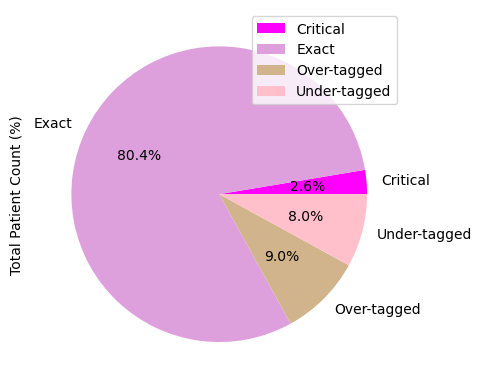

In [10]:

df = error_type_df.groupby('error_type').sum().reset_index()
df.error_type = df.error_type
display(df)
df.plot.pie(
    autopct='%1.1f%%', y='patient_count', ylabel='Total Patient Count (%)', labels=df.error_type.map(suffixed_fn),
    colors=[LABELS_DICT[k] for k in df.error_type]
);

In [11]:

def show_pie_charts(column_name, title_prefix='', suptitle=None):
    
    # Calculate the number of plots and the number of rows and columns
    unique_categories = error_type_df[column_name].unique()
    num_plots = len(unique_categories)
    num_rows = min(num_plots, 2)
    num_cols = int(np.ceil(num_plots / num_rows))
    
    # # Create a figure and subplots
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(18, 9), sharex=False, sharey=False)
    
    for i, column_value in enumerate(unique_categories):
        mask_series = (error_type_df[column_name] == column_value)
        df = error_type_df[mask_series].groupby('error_type').sum().reset_index()
        # display(df)
        df.plot.pie(
            autopct='%1.1f%%', y='patient_count', ylabel='', labels=df.error_type.map(suffixed_fn),
            colors=[LABELS_DICT[k] for k in df.error_type], ax=axs[i // num_cols, i % num_cols], title=f'{title_prefix}{column_value.title()}'
        );
    
    # Remove the remainder of the plots
    i += 1
    while i < (num_rows * num_cols):
        axs[i // num_cols, i % num_cols].remove()
        i += 1

    if suptitle is not None: fig.suptitle(suptitle)


#### Pie charts grouped by last tag

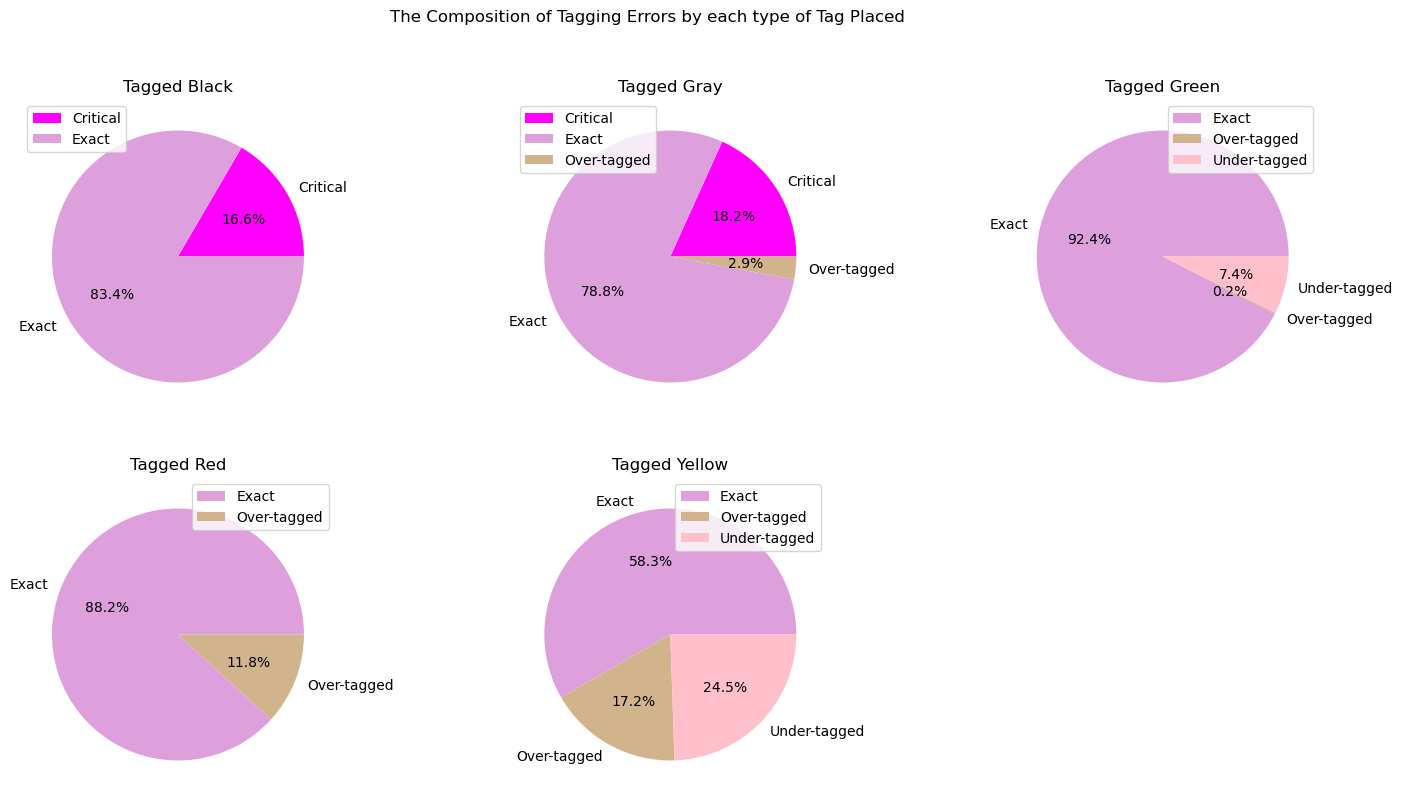

In [12]:

show_pie_charts('last_tag', title_prefix='Tagged ', suptitle='The Composition of Tagging Errors by each type of Tag Placed')


#### Pie charts grouped by max salt

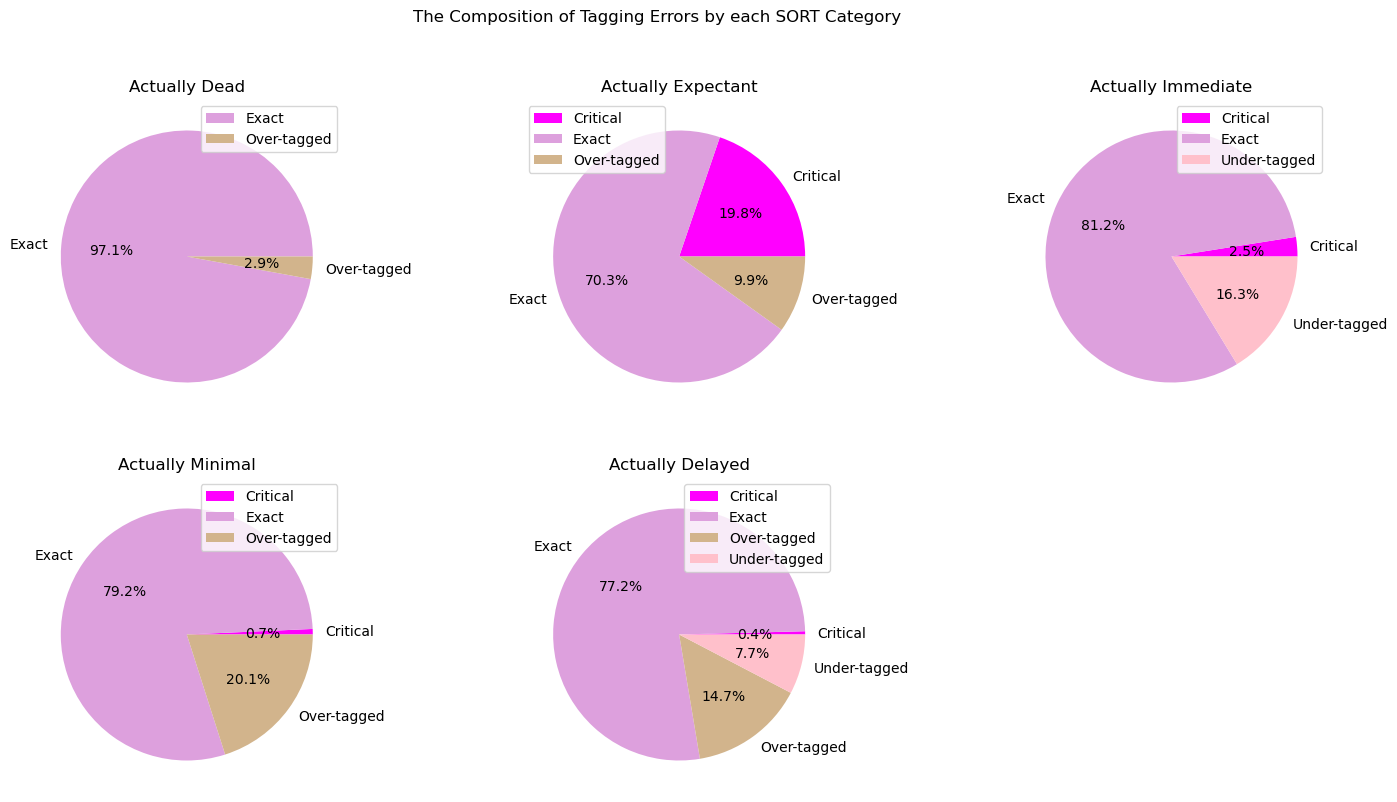

In [13]:

show_pie_charts('max_salt', title_prefix='Actually ', suptitle='The Composition of Tagging Errors by each SORT Category')

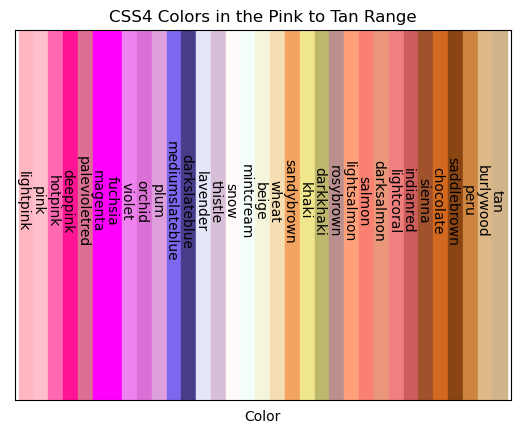

In [14]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Create a list of the CSS4 colors in the pink to tan range
colors = [
    'lightpink', 'pink', 'hotpink', 'deeppink', 'palevioletred', 'magenta',
    'fuchsia', 'violet', 'orchid', 'plum', 'mediumslateblue', 'darkslateblue',
    'lavender', 'thistle', 'snow', 'mintcream', 'beige', 'wheat', 'sandybrown',
    'khaki', 'darkkhaki', 'rosybrown', 'lightsalmon', 'salmon', 'darksalmon',
    'lightcoral', 'indianred', 'sienna', 'chocolate', 'saddlebrown', 'peru',
    'burlywood', 'tan'
]

# Create a figure and axes
fig, ax = plt.subplots()

# Create a rectangle for each color
for i in range(len(colors)):
    ax.add_patch(plt.Rectangle((i, 0), 1, 1, color=colors[i]))

# Set the x and y limits
ax.set_xlim(-0.25, len(colors) + 0.25)
ax.set_ylim(0, 1)

# Set the x and y labels
ax.set_xlabel('Color')

# Turn off the axes
ax.set_axisbelow(True)
ax.set_xticks([])
ax.set_yticks([])

# Set the title
ax.set_title('CSS4 Colors in the Pink to Tan Range')

# Annotate each color
for i in range(len(colors)):
    ax.annotate(
        colors[i],
        xy=(i + 1.25, 0.5),
        xytext=(-10, 10),
        textcoords='offset points',
        fontsize=10,
        ha='center',
        va='center',
        rotation=-90
    )

# Show the plot
plt.show()
